In [80]:
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
2.2.0


In [0]:
# additional imports

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization, SimpleRNN, GRU, LSTM
from tensorflow.keras.models import Model

# Load Data

In [0]:
cifar10 = tf.keras.datasets.cifar10


In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Data Preprocessing

In [0]:
# Normalize data
x_train, x_test = x_train / 255, x_test / 255

In [0]:
# Reshape targets to be vectors
y_train = y_train.flatten()
y_test = y_test.flatten()

# Get number of classes
K = len(set(y_train))

# Build Model

In [86]:
D = x_train[0].shape
print("D: ", D)
k = len(set(y_train))
print("k: ", k)

D:  (32, 32, 3)
k:  10


In [0]:
def create_model():
  i = Input(shape=(32, 32, 3))
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(i) # padding='same' keeps output image size the same
  x = BatchNormalization()(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2, 2))(x) # halve image size
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2, 2))(x) # halve image size
  x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2, 2))(x) # halve image size

  x = Flatten()(x)
  x = Dropout(0.2)(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(10, activation='softmax')(x)

  model = Model(i, x)
  
  return model

## Set Up Distributed Computing Strategy

In [88]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [89]:
print(f"Number of devices: {strategy.num_replicas_in_sync}")

Number of devices: 1


In [0]:
with strategy.scope():

  model = create_model()

  model.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train Model

In [91]:
r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15)

Epoch 1/15
1563/1563 [==============================] - 14s 9ms/step - accuracy: 0.5562 - loss: 1.2896 - val_accuracy: 0.6785 - val_loss: 0.9030
Epoch 2/15
1563/1563 [==============================] - 13s 8ms/step - accuracy: 0.7078 - loss: 0.8388 - val_accuracy: 0.7370 - val_loss: 0.7540
Epoch 3/15
1563/1563 [==============================] - 13s 8ms/step - accuracy: 0.7656 - loss: 0.6842 - val_accuracy: 0.7321 - val_loss: 0.7971
Epoch 4/15
1563/1563 [==============================] - 13s 8ms/step - accuracy: 0.8002 - loss: 0.5795 - val_accuracy: 0.7731 - val_loss: 0.6777
Epoch 5/15
1563/1563 [==============================] - 13s 8ms/step - accuracy: 0.8343 - loss: 0.4833 - val_accuracy: 0.7961 - val_loss: 0.6197
Epoch 6/15
1563/1563 [==============================] - 13s 8ms/step - accuracy: 0.8571 - loss: 0.4144 - val_accuracy: 0.7777 - val_loss: 0.6654
Epoch 7/15
1563/1563 [==============================] - 13s 8ms/step - accuracy: 0.8827 - loss: 0.3433 - val_accuracy: 0.7834 - va

# Evaluate Model

Text(0.5, 0, 'Epoch')

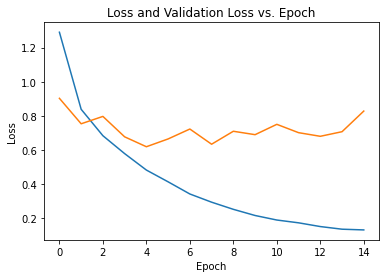

In [92]:
# Plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='loval_lossss')
plt.title("Loss and Validation Loss vs. Epoch")
plt.ylabel('Loss')
plt.xlabel('Epoch')

Text(33.0, 0.5, 'True Label')

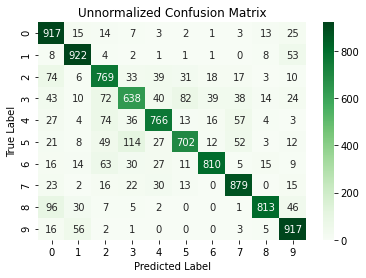

In [93]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

predictions = model.predict(x_test).argmax(axis=1) # Need to take argmax to get class number with highest probability for each sample
colormap = confusion_matrix(y_test, predictions)
import seaborn as sns
ax = sns.heatmap(colormap, annot=True, fmt='d', cmap='Greens')
ax.set_title("Unnormalized Confusion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")



In [95]:
# Compare this to non-distributed training
model2 = create_model()
model2.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
r = model2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15)

Epoch 1/15
1563/1563 [==============================] - 10s 7ms/step - loss: 1.2829 - accuracy: 0.5572 - val_loss: 1.0158 - val_accuracy: 0.6513
Epoch 2/15
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8360 - accuracy: 0.7099 - val_loss: 0.8129 - val_accuracy: 0.7236
Epoch 3/15
1563/1563 [==============================] - 10s 7ms/step - loss: 0.6779 - accuracy: 0.7668 - val_loss: 0.7142 - val_accuracy: 0.7587
Epoch 4/15
1563/1563 [==============================] - 10s 6ms/step - loss: 0.5721 - accuracy: 0.8054 - val_loss: 0.7199 - val_accuracy: 0.7621
Epoch 5/15
1563/1563 [==============================] - 10s 6ms/step - loss: 0.4891 - accuracy: 0.8332 - val_loss: 0.8218 - val_accuracy: 0.7499
Epoch 6/15
1563/1563 [==============================] - 10s 7ms/step - loss: 0.4158 - accuracy: 0.8571 - val_loss: 0.6419 - val_accuracy: 0.7978
Epoch 7/15
1563/1563 [==============================] - 10s 6ms/step - loss: 0.3497 - accuracy: 0.8793 - val_loss: 0.5766 - val_ac